# Road to Generative AI - Part 1: Bigram Models, Neural Networks

## Introduction

The purpose of this notebook is to explore the capabilities of Generative AI. In this first part, we will focus on the most basic form of Generative AI, which is the generation of simple words. We will use a series of model architectures from simple bigram models to more complex RNNs and LSTMs to generate new words based on a dataset of existing words.

## Dataset

For this task, we will build a model that will help us generate new names for the Lord of the Rings universe. We will use the names of the characters in the Lord of the Rings series as our dataset. Our source data can be found [here](https://www.kaggle.com/paultimothymooney/lord-of-the-rings-data).

In [110]:
DATASET_PATH = "./datasets/lotr/lotr_characters_names.csv"

characters = open(DATASET_PATH, "r").read().splitlines()

print(characters[0:10])
print(f"There are {len(characters)} characters in the dataset.")

min_length = map(len, characters)
max_length = map(len, characters)
print(f"The shortest character name has {min(min_length)} characters.")
print(f"The longest character name has {max(max_length)} characters.")

['Adanel', 'Boromir', 'Lagduf', 'Tarcil', 'Fire drake of Gondolin', 'Ar Adûnakhôr', 'Annael', 'Angrod', 'Angrim', 'Anárion']
There are 905 characters in the dataset.
The shortest character name has 3 characters.
The longest character name has 31 characters.


In [111]:
from unidecode import unidecode

def clean_name(name):
    # Remove leading and trailing whitespaces
    # Convert to lowercase
    # Remove accents
    # Remove special characters
    # Replace spaces with underscores

    name = name.strip().lower()
    name = name.replace(" ", "_")
    name = unidecode(name)
    return name

characters = list(map(clean_name, characters))

print(characters[0:10])

['adanel', 'boromir', 'lagduf', 'tarcil', 'fire_drake_of_gondolin', 'ar_adunakhor', 'annael', 'angrod', 'angrim', 'anarion']


## Bigram Model

The simplest form of Generative AI is the bigram model. In this model, we calculate the probability of each character in the dataset based on the previous character. We then use these probabilities to generate new characters. Let's start by building a bigram model for our dataset.

A language model leads the conditional probabilities $P(c_i|c_{i-1})$ where $c_i$ is the $i$-th character in the dataset. We can calculate these probabilities by counting the number of times each character appears after the previous character in the dataset. Then at prediction time, we can generate new characters by sampling from the conditional probabilities.

For the name "adanel", the model needs to understand that the first "a" is the first character and that the "l" is the last character. To do so, we are going to add a start/end token `<.>` at the beginning of each name and at end of each name.

In [112]:
SPECIAL_TOKEN = "<.>"

for w in characters[0:1]:
    w = [SPECIAL_TOKEN] + list(w) + [SPECIAL_TOKEN]
    for c1, c2 in zip(w, w[1:]):
        print(c1, "->", c2)

<.> -> a
a -> d
d -> a
a -> n
n -> e
e -> l
l -> <.>


Now we generate a dictionary that contains the conditional probabilities for each character in the dataset. We will use this dictionary to generate new names.

In [113]:
bigrams = {}

for w in characters:
    w = [SPECIAL_TOKEN] + list(w) + [SPECIAL_TOKEN]
    for c1, c2 in zip(w, w[1:]):
        bigram = (c1, c2)
        bigrams[bigram] = bigrams.get(bigram, 0) + 1

# print a sample of 5 bigrams
for c1 in list(bigrams.keys())[0:5]:
    print(c1, bigrams[c1])

('<.>', 'a') 101
('a', 'd') 53
('d', 'a') 56
('a', 'n') 184
('n', 'e') 44


In [114]:
print(f"There are {len(bigrams)} bigrams in the dataset.")
print("The most common bigrams are:")
sorted(bigrams.items(), key=lambda x: x[1], reverse=True)[0:5]

There are 433 bigrams in the dataset.
The most common bigrams are:


[(('a', 'r'), 220),
 (('i', 'n'), 209),
 (('r', '<.>'), 190),
 (('a', 'n'), 184),
 (('o', 'r'), 170)]

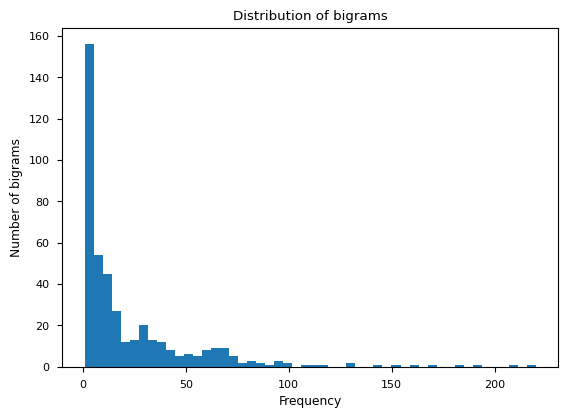

In [115]:
# plot the distribution of bigrams
import matplotlib.pyplot as plt
%matplotlib inline

# set the style
plt.style.use("seaborn-v0_8-paper")

plt.hist(bigrams.values(), bins=50)
plt.xlabel("Frequency")
plt.ylabel("Number of bigrams")
plt.title("Distribution of bigrams")
plt.show()

In [116]:
unique_tokens = set([c for w in characters for c in w])
unique_tokens.add(SPECIAL_TOKEN)
unique_tokens.add(SPECIAL_TOKEN)
N_TOKENS = len(unique_tokens)
print(f"There are {len(unique_tokens)} unique tokens in the dataset.")
print(sorted(unique_tokens))

There are 28 unique tokens in the dataset.
['<.>', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


For efficiency, we are going to use a 2D Pytorch tensor to store the conditional probabilities. The first dimension will represent the previous character, and the second dimension will represent the current character. The value at index `[i, j]` will represent the probability of character `j` appearing after character `i`.

$$N = \begin{bmatrix} C(c_1|c_1) & C(c_2|c_1) & \cdots & C(c_n|c_1) \\ C(c_1|c_2) & C(c_2|c_2) & \cdots & C(c_n|c_2) \\ \vdots & \vdots & \ddots & \vdots \\ C(c_1|c_n) & C(c_2|c_n) & \cdots & C(c_n|c_n) \end{bmatrix}$$

In oder to populate the array, we need a lookup table that maps each character to an index in the array. We will also need a reverse lookup table that maps each index to a character.

In [117]:
# create a mapping from tokens to indices
index_to_token = dict(enumerate(sorted(unique_tokens)))
token_to_index = {v: k for k, v in index_to_token.items()}
# print a few examples
print("Index to token:")
print({k: index_to_token[k] for k in range(10)})

Index to token:
{0: '<.>', 1: '_', 2: 'a', 3: 'b', 4: 'c', 5: 'd', 6: 'e', 7: 'f', 8: 'g', 9: 'h'}


In [118]:
import torch

# create our bigram array
N = torch.zeros(N_TOKENS, N_TOKENS, dtype=torch.int32)

# populate the bigram array
for w in characters:
    w = [SPECIAL_TOKEN] + list(w) + [SPECIAL_TOKEN]
    for c1, c2 in zip(w, w[1:]):
        N[token_to_index[c1], token_to_index[c2]] += 1

(-0.5, 27.5, 27.5, -0.5)

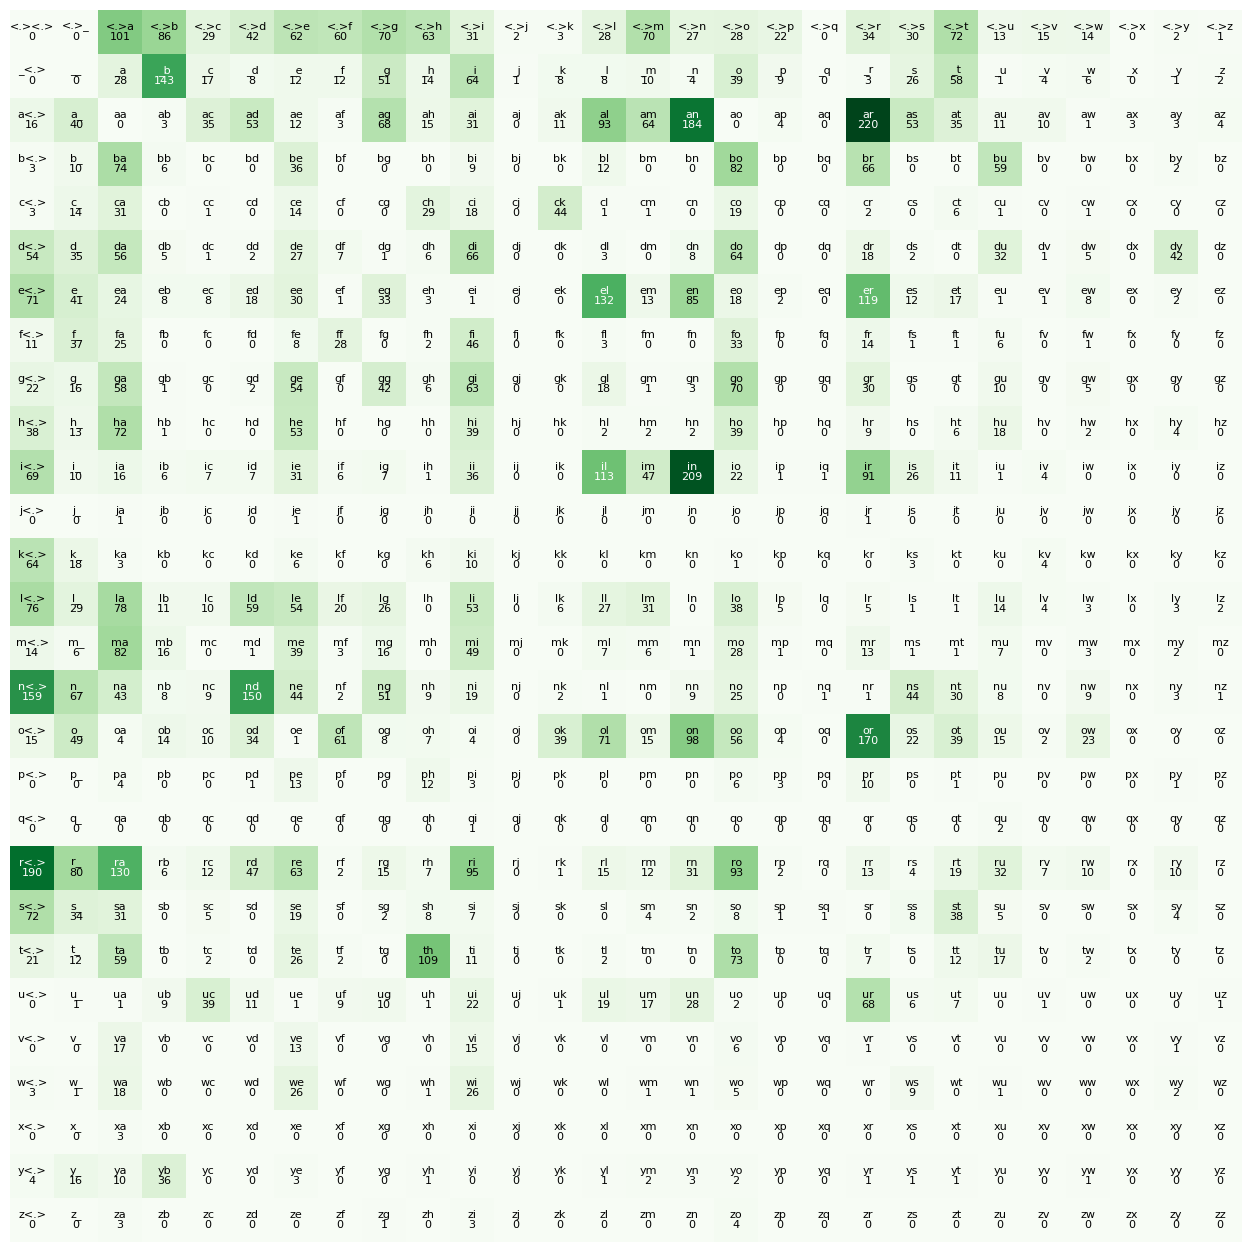

In [119]:
# plot heatmap of bigram array
fig, ax = plt.subplots(figsize=(16, 16))
plt.imshow(N, cmap="Greens")
for i in range(N_TOKENS):
    for j in range(N_TOKENS):
        bigram = index_to_token[i] + index_to_token[j]
        plt.text(j, i, bigram, ha="center", va="bottom", color="white" if N[i, j] > N.max() / 2 else "black", fontsize=8)
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color="white" if N[i, j] > N.max() / 2 else "black", fontsize=8)
plt.axis("off")

In the above chart, the first row represents the count of each character as the first character in the name. The first column represents the count of each character as the last character in the name.

We can now normalize the counts to get the probabilities.

$$P(c_i|c_{j}) = \frac{C(c_i|c_j)}{\sum_{k=1}^{n} C(c_k|c_j)}$$

The temperature parameter controls the randomness of the generated names. A higher temperature will result in more random names, while a lower temperature will result in names that are more similar to the original dataset. To prevent hard exceptions, we add a small epsilon value to the probabilities before normalizing them (smoothing). This allows for the unseen bigrams to have a small probability of occurring.

In [120]:
# normalize the bigram array
P = N.float() + 1 # 28x28
# use broadcasting to normalize the bigram array
P /= P.sum(dim=1, keepdim=True) # 28x28 / 28x1 = 28x28

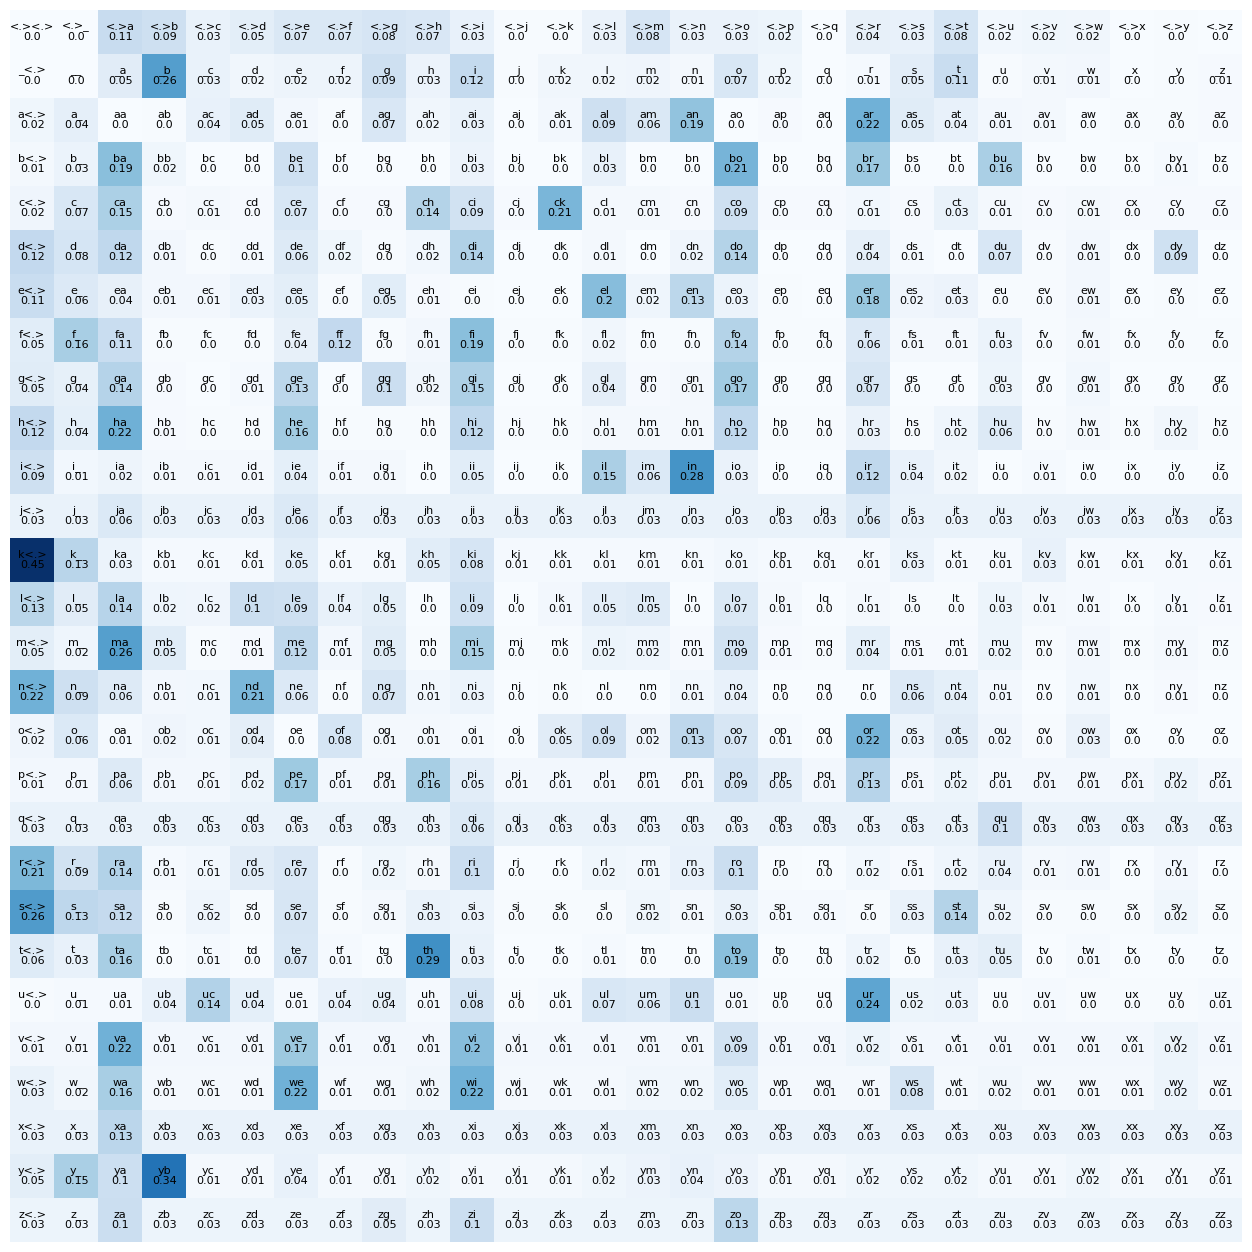

In [121]:
# plot heatmap of bigram array
fig, ax = plt.subplots(figsize=(16, 16))
plt.imshow(P, cmap="Blues")
for i in range(N_TOKENS):
    for j in range(N_TOKENS):
        bigram = index_to_token[i] + index_to_token[j]
        plt.text(j, i, bigram, ha="center", va="bottom", color="white" if P[i, j] > 0.5 else "black", fontsize=8)
        plt.text(j, i, round(P[i, j].item(),2), ha="center", va="top", color="white" if P[i, j] > 0.5 else "black", fontsize=8)
plt.axis("off");

In [122]:
# seed the random generator
g = torch.Generator().manual_seed(42)

In [123]:
def sample_following_token(token: str, temperature: float=1.0):
    # get the row corresponding to the token
    probabilities = P[token_to_index[token], :].float()
    if temperature != 1.0:
        # apply temperature
        probabilities = probabilities ** (1 / temperature)
        # normalize the adjusted probabilities
        probabilities = probabilities / probabilities.sum()
    # sample from the distribution
    return torch.multinomial(probabilities, 1, replacement=True, generator=g).item()

In [124]:
print("Here is a sample of 5 tokens following the token 'a':")
sample = [index_to_token[sample_following_token("a")] for _ in range(5)]
print(sample)

Here is a sample of 5 tokens following the token 'a':
['x', 'd', 'n', 'r', 'l']


In [125]:
def generate_name(max_length:int=20, temperature:float=1.0):
    name: str = ""
    previous_token = SPECIAL_TOKEN
    while len(name) < max_length:
        next_token = index_to_token[sample_following_token(previous_token, temperature)]
        if next_token == SPECIAL_TOKEN:
            break
        name += next_token
        previous_token = next_token
    return name.replace("_", " ")

In [126]:
# create a few names
print("Here are a few generated names:")
for i in range(10):
    print(generate_name())

Here are a few generated names:
filunand
tubansal
menisamacxavanbudond
maduk
olih bagageldr
ar
f
ndy busth
oton
bumeyaren


As we can see, the bigram model is not very effective at generating new names. The names it generates are often nonsensical and do not resemble the names in the dataset. This is because the bigram model does not capture the dependencies between characters in the dataset but only the dependencies between adjacent characters.

If we were to expand the model to an N-gram model, we would be able to capture more complex dependencies between characters in the dataset. However, this would require a much larger dataset and more computational resources. Indeed, with 5-grams, we would need to store $28^5 = 17,210,368$ probabilities in our tensor.

In order to evaluate the quality of generative models, we can compute the likelihood of the dataset under the model. The likelihood is the probability of generating the dataset under the model. A higher likelihood indicates that the model is better at generating the dataset.

For example, the likelihood of the dataset "adanel" under the bigram model is:

$$P(adanel) = P(a|<.>) \times P(d|a) \times P(a|d) \times P(n|a) \times P(e|n) \times P(l|e)\times P(<.>|l)$$

Because the likelihood of a given name is a product of small probabilities, it can be very small. To avoid numerical underflow, we can compute the log-likelihood instead and in order to use it as a loss function, we can take the average negative log-likelihood.

$$Loss(adanel) = -\frac{1}{6} \sum_{i=1}^{6} \log P(c_i|c_{i-1})$$

In [127]:
def negative_log_likelihood(name: str):
    name = [SPECIAL_TOKEN] + list(clean_name(name)) + [SPECIAL_TOKEN]
    log_prob = 0.0
    for c1, c2 in zip(name, name[1:]):
        log_prob -= torch.log(P[token_to_index[c1], token_to_index[c2]])
    log_prob /= len(name) - 1
    return log_prob

In [128]:
print("Here is the log-likelihood of a few names:")
for name in ["frodo", "gandalf", "aragorn", "legolas", "gimli"]:
    print(f"{name}: {negative_log_likelihood(name):.3f}")

Here is the log-likelihood of a few names:
frodo: 2.797
gandalf: 2.326
aragorn: 2.069
legolas: 2.409
gimli: 2.613


In [129]:
total_log_likelihood = sum([negative_log_likelihood(w) for w in characters])
print(f"The sum of the average negative log-likelihood of the entire dataset is: {total_log_likelihood:,.3f}")
print(f"The average negative log-likelihood over the entire dataset is: {total_log_likelihood / len(characters):,.3f}")
print(f"This corresponds to an average expected bigram probability of {torch.exp(-total_log_likelihood / len(characters)).item():,.3f} instead of 1.")
print(f"A random model would have an average negative log-likelihood of {-torch.log(torch.tensor(1.0 / N_TOKENS)).item():,.3f} with a corresponding average expected bigram probability of {1 / N_TOKENS:,.3f} (i.e. 1/{N_TOKENS}).")

The sum of the average negative log-likelihood of the entire dataset is: 2,214.287
The average negative log-likelihood over the entire dataset is: 2.447
This corresponds to an average expected bigram probability of 0.087 instead of 1.
A random model would have an average negative log-likelihood of 3.332 with a corresponding average expected bigram probability of 0.036 (i.e. 1/28).


## Neural Networks

To overcome the limitations of the bigram model, we can use neural networks to build more complex language models.

For more information about Neural Networks, you can refer to [Part 2](https://tdody.github.io//Neural-Network/) and [Part 3](https://tdody.github.io//Deep-Neural/) of my Road to Deep Learning series.

### Architecture

We will use a simple feedforward neural network to build our language model. The input to the network will be the one-hot encoded representation of the previous character, and the output will be the probability distribution over the characters in the dataset. We will use the softmax activation function to compute the probabilities.

The one-hot encoded representation of a character is a vector of zeros with a one at the index corresponding to the character. For example, the one-hot encoded representation of the character "a" in a dataset with 28 characters would be [0, 1, 0, 0, ..., 0]. This vector is then fed to a linear layer with 27 output units (one for each character in the dataset) and a softmax activation function to compute the probabilities.

### Training Data

In [130]:
xs, ys = [], []

# populate the training dataset and corresponding labels
for w in characters:
    w = [SPECIAL_TOKEN] + list(w) + [SPECIAL_TOKEN]
    for c1, c2 in zip(w, w[1:]):
        xs.append(token_to_index[c1])
        ys.append(token_to_index[c2])

xs = torch.tensor(xs)
ys = torch.tensor(ys)

The encoded tensor has shape: torch.Size([10152, 28])


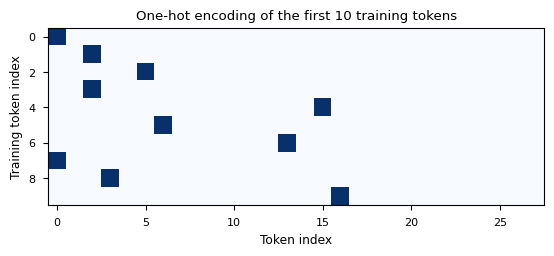

In [131]:
xenc = torch.nn.functional.one_hot(xs, N_TOKENS).float()
print(f"The encoded tensor has shape: {xenc.shape}")

plt.imshow(xenc[0:10, :], cmap="Blues", aspect=1)
plt.xlabel("Token index")
plt.ylabel("Training token index")
plt.title("One-hot encoding of the first 10 training tokens");

As shown in the above chart, a single bit is set to 1 in the one-hot encoded representation of the previous character. This bit corresponds to the index of the character in the dataset.

Our initial model will be structured using the following equation: $$Y = \text{softmax}(XW);\text{ shape: (1x27) x (27x27) = (1x27)}$$

Where $X$ is a vector of shape `(1, 27)` representing the one-hot encoded representation of the previous character, $W$ is a matrix of shape `(27, 27)` representing the weights of the linear layer, and $Y$ is a vector of shape `(1, 27)` representing the probability distribution over the characters in the dataset.

The softmax function is defined as: $$\text{softmax}(XW) = \frac{e^{z_i}}{\sum_{j=1}^{n} e^{z_j}}$$

Therefore, the $e^{z_i}$ can be interpreted as the count of the character $i$ when preceded by the input character $X$ fed to the model.

In [132]:
INPUT_SIZE = N_TOKENS
OUTPUT_LAYER = N_TOKENS

print(f"Our simple NN model contains {INPUT_SIZE * OUTPUT_LAYER} parameters")

Our simple NN model contains 784 parameters


In [133]:
# randomly initialize the weights
W = torch.randn(INPUT_SIZE, OUTPUT_LAYER, requires_grad=True, generator=g) # 28x28
# compute the logits
logits = xenc @ W # kx28 @ 28x28 = kx28
# compute the artificial counts
counts = logits.exp() # kx28
# normalize the counts
probs = counts / counts.sum(dim=1, keepdim=True) # kx28 / kx1 = kx28
# compute the negative log-likelihood
loss = -probs[range(len(xs)), ys].log().mean()

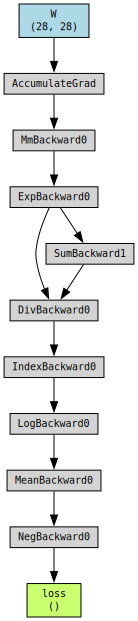

In [134]:
import torchviz

# plot compute graph
torchviz.make_dot(loss, params={"W":W, "logits":logits, "counts":counts, "probs":probs, "loss":loss})

In [135]:
for i in range(6):
    x = xs[i].item()
    y = ys[i].item()
    print(f"Bigram {i}: {index_to_token[x]}{index_to_token[y]} ({x} -> {y})")
    print(f"Input vector X: {x}")
    print(f"Output probability vector : {probs[i]:}")
    print(f"Actual output : {y}")
    print(f"Probability of the correct token: {probs[i, y]:.3f}")
    print(f"Negative log likelihood of the correct token: {-torch.log(probs[i, y]):.3f}")
    print("=========================================================\n")

Bigram 0: <.>a (0 -> 2)
Input vector X: 0
Output probability vector : tensor([0.0064, 0.0169, 0.0009, 0.0171, 0.0230, 0.0108, 0.0199, 0.0188, 0.0131,
        0.0183, 0.0087, 0.0223, 0.0158, 0.0126, 0.0137, 0.0375, 0.0043, 0.0158,
        0.0024, 0.0095, 0.0058, 0.0169, 0.0217, 0.0115, 0.5946, 0.0378, 0.0104,
        0.0134], grad_fn=<SelectBackward0>)
Actual output : 2
Probability of the correct token: 0.001
Negative log likelihood of the correct token: 7.065

Bigram 1: ad (2 -> 5)
Input vector X: 2
Output probability vector : tensor([0.0060, 0.0426, 0.0358, 0.0665, 0.0159, 0.1258, 0.0021, 0.0167, 0.0208,
        0.0486, 0.0038, 0.0318, 0.0259, 0.0179, 0.0337, 0.0122, 0.1090, 0.0185,
        0.0051, 0.0978, 0.0917, 0.0266, 0.0054, 0.0539, 0.0141, 0.0171, 0.0262,
        0.0285], grad_fn=<SelectBackward0>)
Actual output : 5
Probability of the correct token: 0.126
Negative log likelihood of the correct token: 2.073

Bigram 2: da (5 -> 2)
Input vector X: 5
Output probability vector : tens

In [136]:
# define the learning rate
LEARNING_RATE = 50

In [137]:
# randomly initialize the weights
W = torch.randn(INPUT_SIZE, OUTPUT_LAYER, requires_grad=True, generator=g) # 28x28

In [142]:
losses = []

for i in range(100):

    # forward pass
    # compute the logits
    logits = xenc @ W # kx28 @ 28x28 = kx28
    # compute the artificial counts
    counts = logits.exp() # kx28
    # normalize the counts
    probs = counts / counts.sum(dim=1, keepdim=True) # kx28 / kx1 = kx28
    # compute the negative log-likelihood and include L2 regularization
    loss = -probs[range(len(xs)), ys].log().mean() + 0.00001 * (W ** 2).sum()

    losses.append(loss.item())
    if i % 10 == 0:
        print(f"Epoch {i + 1} - Loss: {loss.item():.3f}")

    # backward pass
    # reset gradients
    W.grad = None
    # compute the gradients
    loss.backward()
    # update the weights
    W.data += - LEARNING_RATE * W.grad
    

Epoch 1 - Loss: 2.471
Epoch 11 - Loss: 2.462
Epoch 21 - Loss: 2.456
Epoch 31 - Loss: 2.452
Epoch 41 - Loss: 2.449
Epoch 51 - Loss: 2.447
Epoch 61 - Loss: 2.446
Epoch 71 - Loss: 2.444
Epoch 81 - Loss: 2.443
Epoch 91 - Loss: 2.443


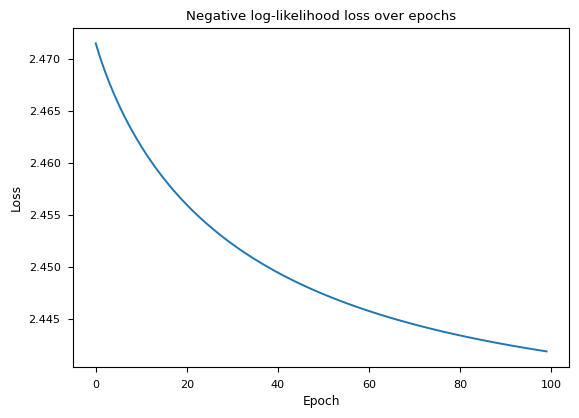

In [143]:
fig, ax = plt.subplots()
ax.plot(losses)
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Negative log-likelihood loss over epochs");

We archive a loss of approximately 2.44 after 100 epochs. The simple bigram model has a loss of 2.45. The relatively similar loss values are to be expected as the neural network is essentially learning the same thing as the bigram model, but in a more complex way.

In [144]:
# the bigram total loss is stored under `total_log_likelihood`
bigram_mean_loss = total_log_likelihood / len(characters)
print(f"The mean negative log-likelihood for the bigram model is: {bigram_mean_loss:,.3f}")
# the NN total loss is the last element of the `losses` list
print(f"The total negative log-likelihood of the dataset using the NN is: {losses[-1]:,.3f}")

The mean negative log-likelihood for the bigram model is: 2.447
The total negative log-likelihood of the dataset using the NN is: 2.442


In [145]:
def generate_name_nn(max_length:int=20, temperature:float=1.0):
    name: str = ""
    previous = SPECIAL_TOKEN
    while len(name) < max_length:
        # encode the previous token
        x = torch.nn.functional.one_hot(torch.tensor(token_to_index[previous]), N_TOKENS).float()
        # compute the logits
        logits = x @ W
        # compute the artificial counts
        counts = logits.exp()
        # normalize the counts
        probs = counts / counts.sum()
        # sample the next token
        next_token = index_to_token[torch.multinomial(probs, 1).item()]
        if next_token == SPECIAL_TOKEN:
            break
        name += next_token
        previous = next_token

    return name.replace("_", " ")

print("Here are a few generated names using the NN model:")
for i in range(10):
    print(generate_name_nn())

Here are a few generated names using the NN model:
d bood
beouchehjss
ad ilman
agmandamrivocondudon
im
eler
av
eeldasi
ar
armortr


## References

- [Lord of the Rings Data](https://www.kaggle.com/paultimothymooney/lord-of-the-rings-data)